In [1]:
import os
import numpy as np
import pandas as pd
import geopandas as gpd
from datetime import date, timedelta
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
import spotpy
from scipy import stats

import cartopy.feature as cfeature
import numpy as np
import cartopy.crs as ccrs
import cartopy
import colorcet as cc
from cmcrameri import cm
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import proplot as pplt

#warning
import warnings
warnings.filterwarnings('ignore')

In [2]:
#############################################################
#os.chdir('D:/XanthosDev/Results_11072021/94')
#os.chdir('D:/XanthosDev/Results_11072021/Result_100k')
basinName = pd.read_csv('D:/XanthosDev/example/input/reference/BasinNames235.txt')
basin_id = pd.read_csv('D:/XanthosDev/example/input/reference/basin.csv')
#GRDC_xanthosCoordIndx = pd.read_csv('/project/hli/gabeshu/Guta_Working/Basins_Result/UScells/inputs/GRDC_xanthosCoordIndx.csv')
GRDC_xanthosCoordIndx = pd.read_csv('D:/XanthosDev/example/input/GRDC_stations_selected_final_list.csv')

indx_f = ~((GRDC_xanthosCoordIndx['basins']==58) | (GRDC_xanthosCoordIndx['basins']==84) | (GRDC_xanthosCoordIndx['basins']==169))
GRDC_xanthosCoordIndx = GRDC_xanthosCoordIndx[indx_f].reset_index(drop=True)

basins94 = np.array(GRDC_xanthosCoordIndx['basins']).astype(np.int64)
xanthosid = np.array(GRDC_xanthosCoordIndx['xanthosID_new_adj']).astype(np.int64)
basinName_94 = []
for ii in range(91):
    indx_basin = basins94[ii] - 1
    basinName_94.append(basinName['BName'][indx_basin])


In [3]:
def timeseries_coverter(data_array, start_yr, ending_yr):
    import numpy as np
    from datetime import date, timedelta
    sdate = date(start_yr,1,1)
    edate = date(ending_yr, 12, 31)  
    data_ts = pd.DataFrame(data_array)
    data_ts.index = pd.date_range(start=sdate, end=edate, freq='MS')

    return data_ts

## Calibration

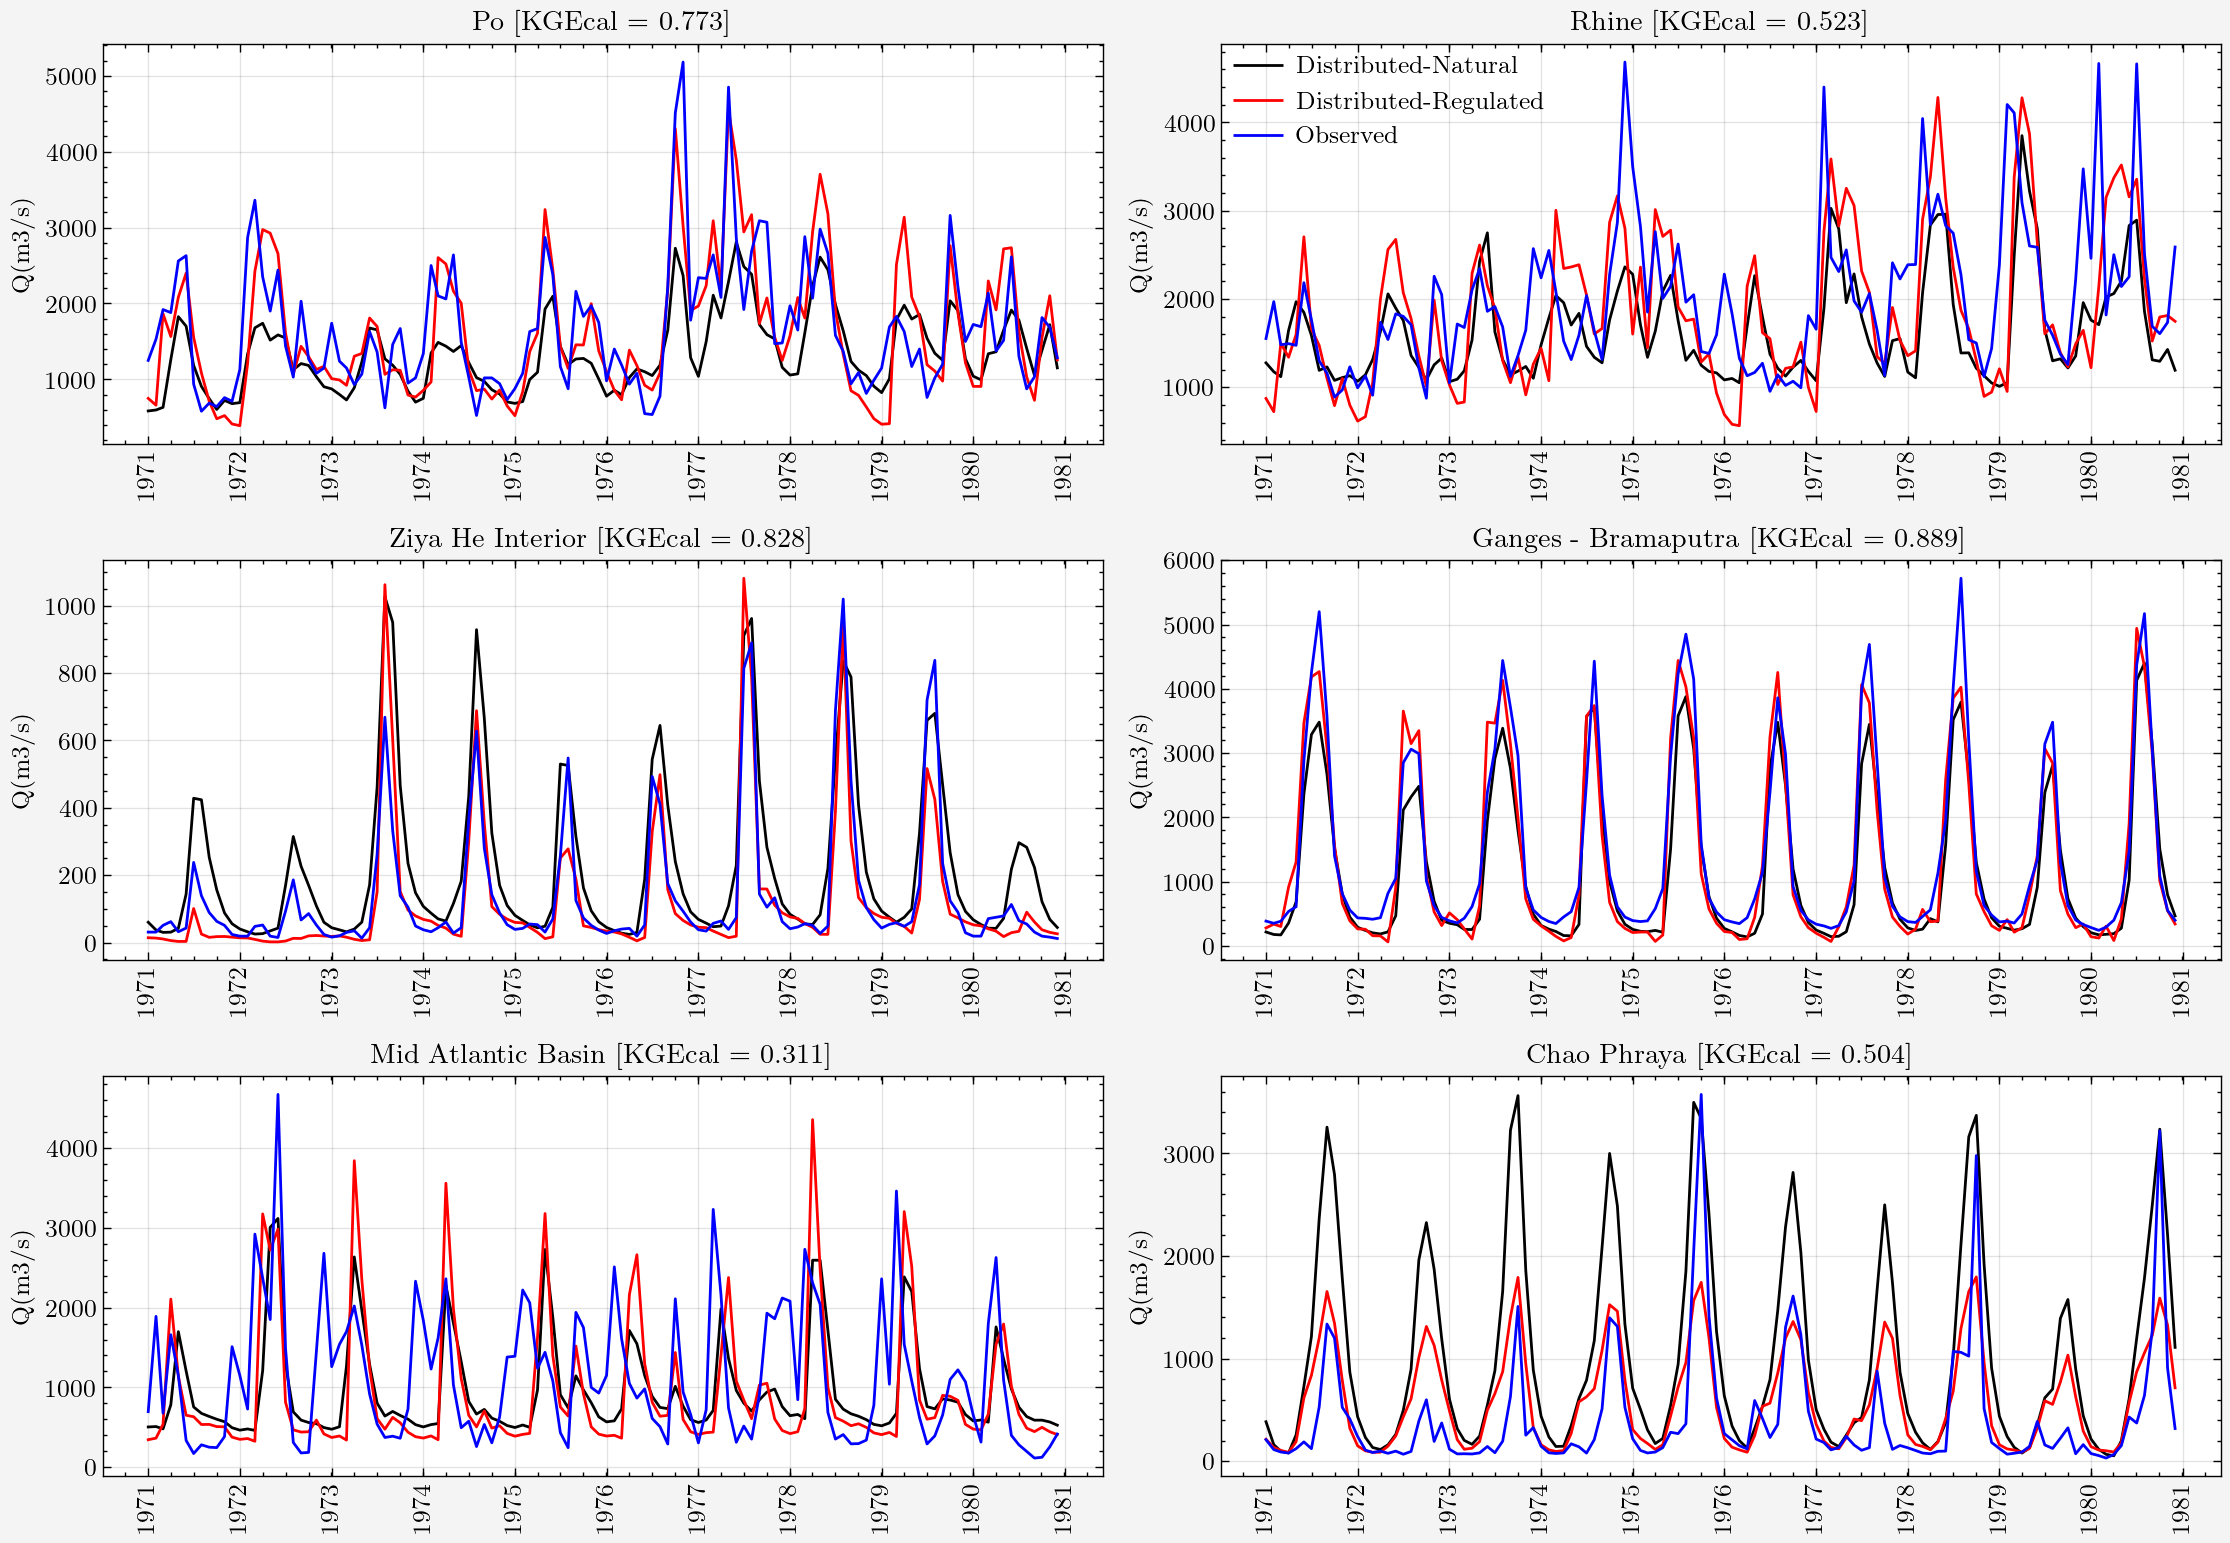

In [4]:
import scipy.io as scio
SAVE_KWDS = {"bbox_inches": "tight", "dpi": 450, "facecolor": "w"}

grdc_basin_m3persec  =  pd.read_csv('D:/XanthosDev/example/input/calibration/grdc_95basin_m3persec_1971_1990_monthly.csv')
file_dir_watch_vald = 'D:\\XanthosDev\\Results-02-27-2022\\Simulated\\SimulatedFinal-HP\\flow\\'
file_dir_watch_natr = 'D:\\XanthosDev\\Results-02-27-2022\\Simulated\\SimulatedFinal-YL\\flow\\'
dir_save_file = 'C:\\Users\\gwabeshu.COUGARNET\\OneDrive - University Of Houston\Desktop\\Xanthos-Manuscript\\figures\\codes\\SDI\\'
#basin_4 = basins94[mm]
basin_slt = [57, 32, 77, 110, 233, 146]
plt.style.use('science')
with plt.style.context(['science', 'high-contrast']):
    fig, ax = pplt.subplots(ncols=2, nrows=3,refaspect=1, refheight=2.0, refwidth=5.0, share=0)
    for jj in range(6):
        basin_num = basin_slt[jj]    
        ii = np.where(basins94==basin_num)[0][0]
        basin_num = basins94[ii]    

        ## observed
        aa = (grdc_basin_m3persec['basin'] == basin_num)
        grdc_m3persec = np.array(grdc_basin_m3persec[aa]['q'])
        qobs_calibration= grdc_m3persec[0:120]
        qobs_validation = grdc_m3persec[120:240]    
        qobs_calibration_ts = timeseries_coverter(qobs_calibration, start_yr=1971, ending_yr=1980)

        ## simulated
        data_basin = np.load(file_dir_watch_vald + 'SimFlow_' + str(basin_num) + '.npy') 
        scio.savemat(dir_save_file + 'Basin_' + str(basin_num) + '.mat', {'Qsim': data_basin})
        scio.savemat(dir_save_file + 'GRDC_Basin_' + str(basin_num) + '.mat', {'Qgrdc': grdc_m3persec})
        qsim_calibration= data_basin[0:120]
        qsim_validation = data_basin[120:240]
        qsim_calibration_ts = timeseries_coverter(qsim_calibration, start_yr=1971, ending_yr=1980)

        ## Natural
        data_basin_yl = np.load(file_dir_watch_natr + 'SimFlow_' + str(basin_num) + '.npy')   
        qsim_calibration_yl= data_basin_yl[0:120]
        qsim_validation_yl = data_basin_yl[120:240]
        qsim_calibration_tsyl = timeseries_coverter(qsim_calibration_yl, start_yr=1971, ending_yr=1980)




        
        
        # KGE
        kge_cal = spotpy.objectivefunctions.kge(qobs_calibration, qsim_calibration) 

        # plotting
        ax[jj].plot(qsim_calibration_tsyl, 'k', label='Distributed-Natural')
        ax[jj].plot(qsim_calibration_ts, 'r', label='Distributed-Regulated')
        ax[jj].plot(qobs_calibration_ts, 'b', label='Observed')
        ax[jj].format(ylabel = 'Q(m3/s)', title = basinName_94[ii])
        ax[jj].format(ylabel = 'Q(m3/s)', title = basinName_94[ii] + ' [KGEcal = '+ str(np.round(kge_cal,3))  +']')

        if jj==1:
            ax[jj].legend(ncols=1)

os.chdir('D:\XanthosDev\Results-02-27-2022\Figures')
plt.savefig("6Basins_WATCH-Calibration.png", **SAVE_KWDS)  

## Validation

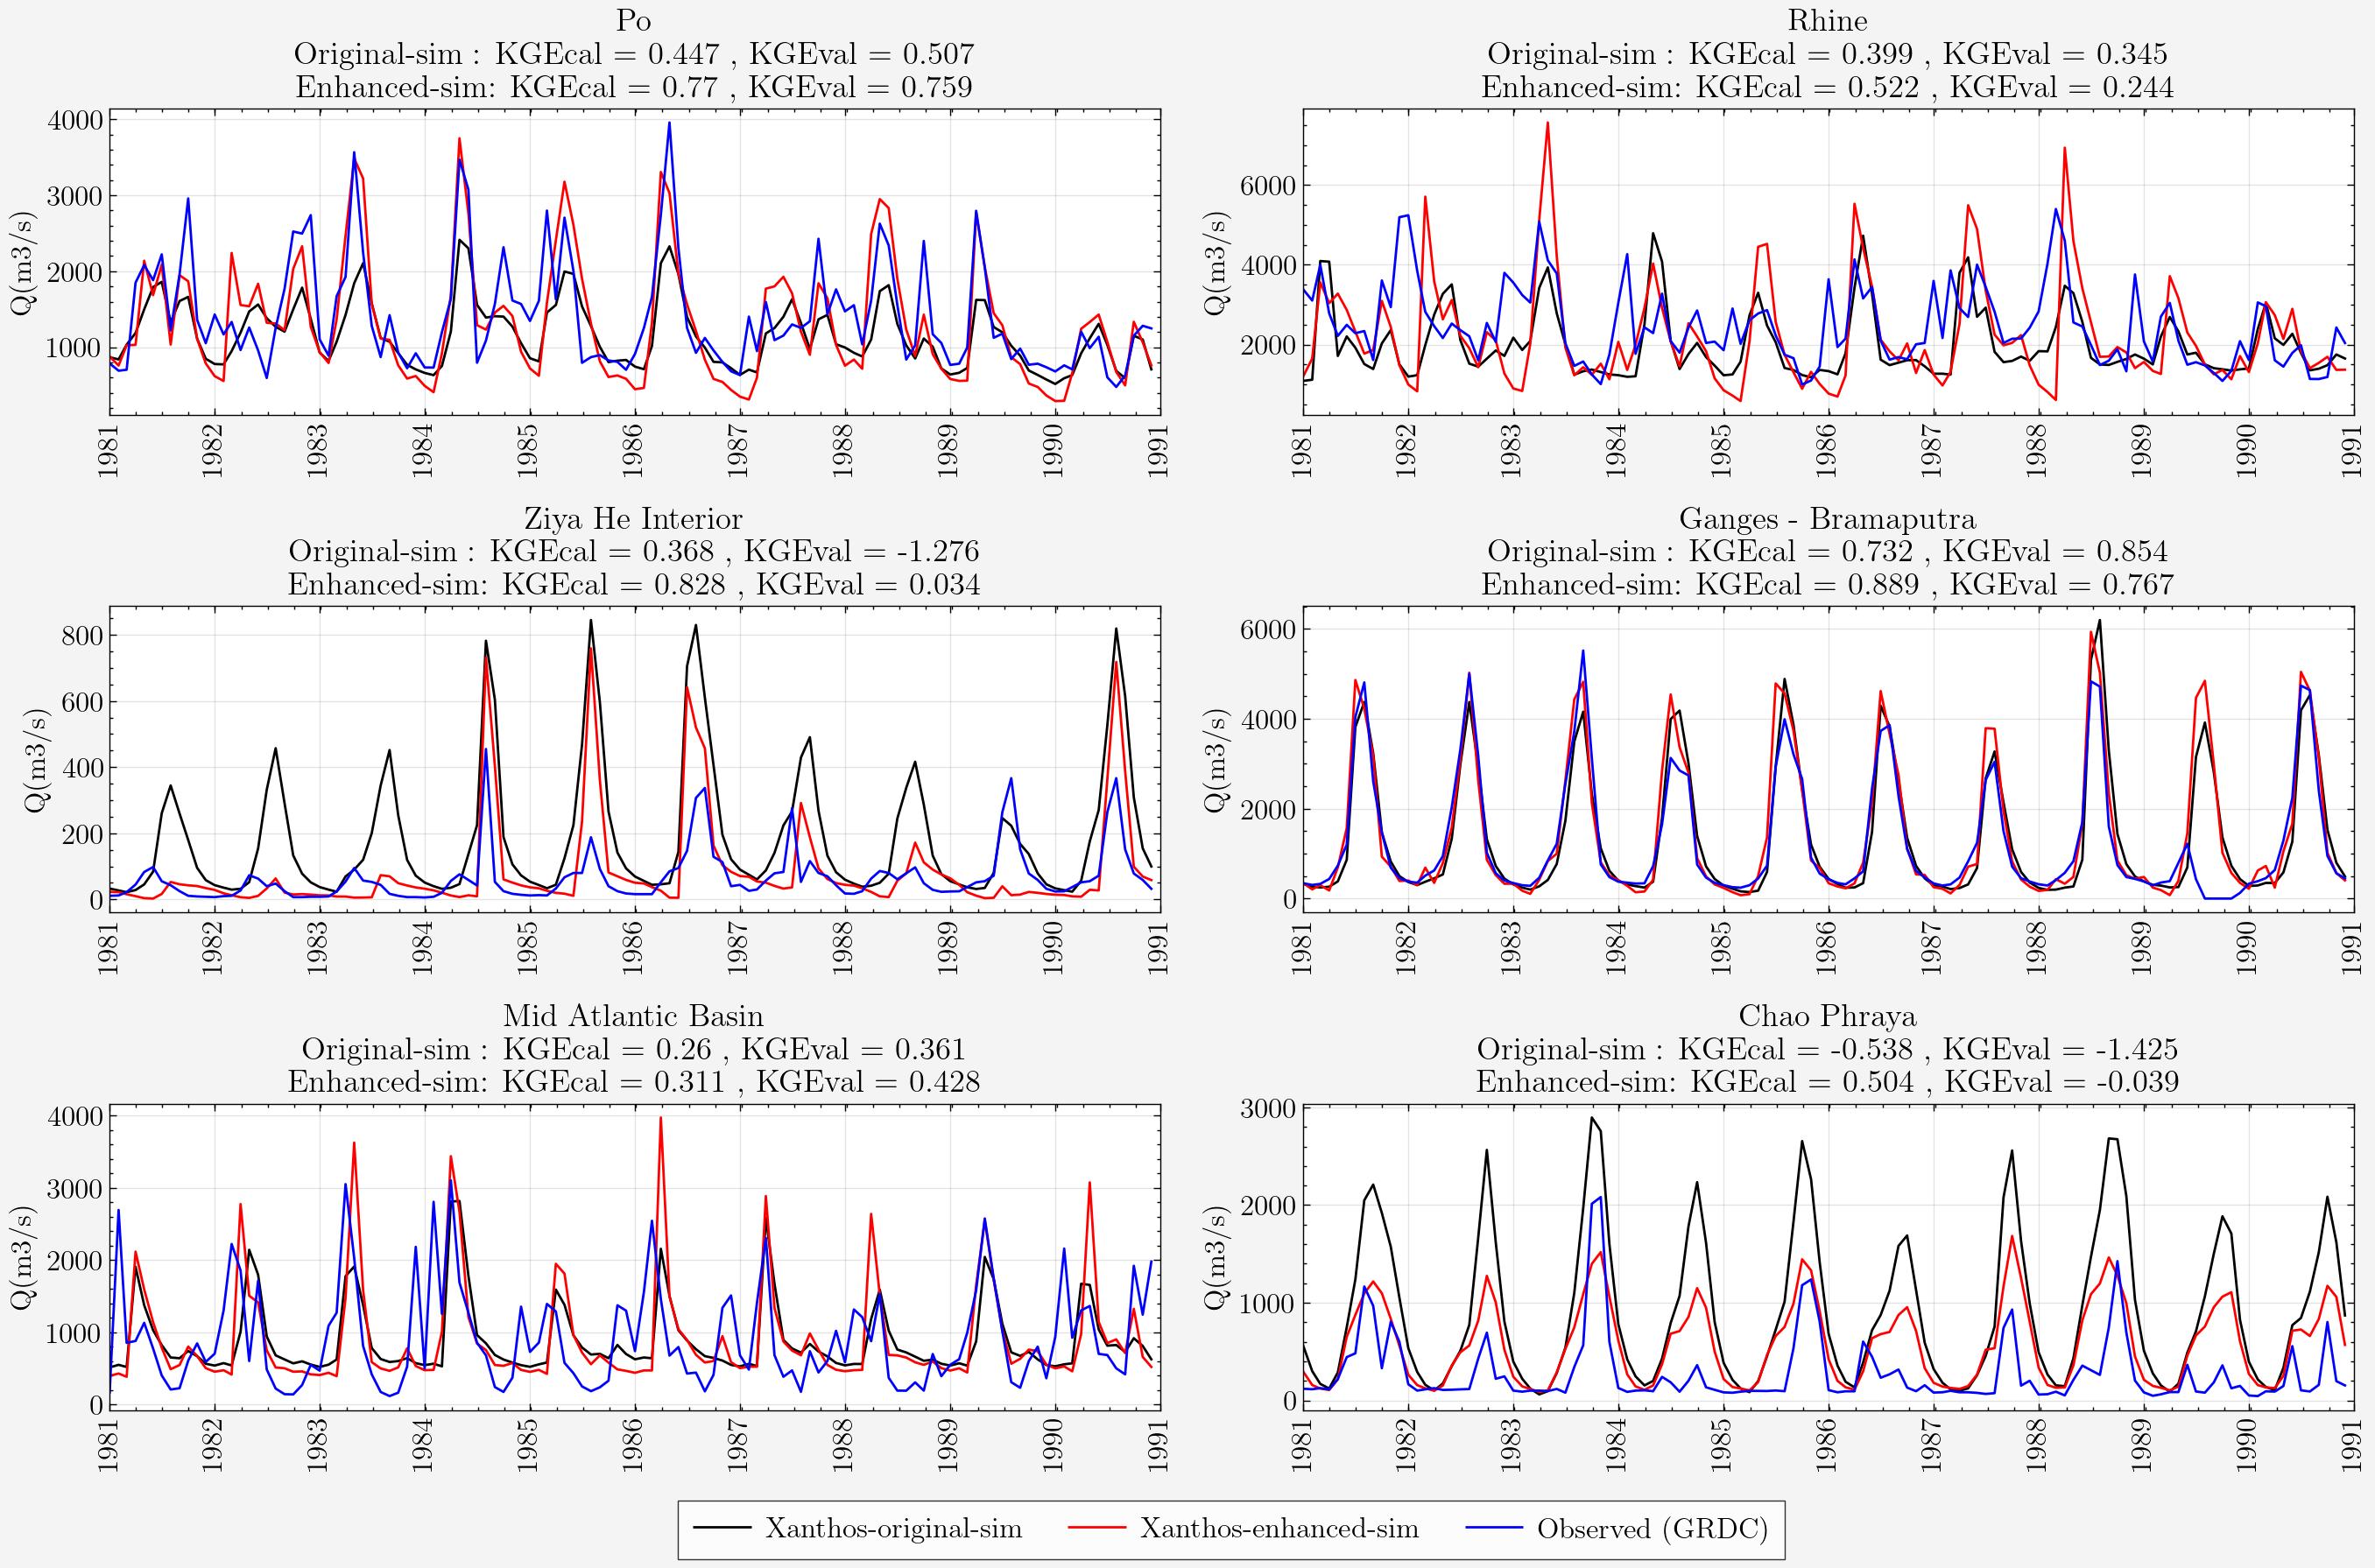

In [7]:
import datetime
import cartopy.feature as cfeature
import numpy as np
import cartopy.crs as ccrs
import cartopy
import colorcet as cc
from cmcrameri import cm
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import proplot as pplt
import xarray 
from sklearn.preprocessing import MinMaxScaler
from scipy import stats
from scipy.optimize import curve_fit
plt.rcParams['figure.autolayout'] = True 
plt.rcParams.update({'font.size': 12}) 



SAVE_KWDS = {"bbox_inches": "tight", "dpi": 450, "facecolor": "w"}
#basin_4 = basins94[mm]
basin_slt = [57, 32, 77, 110, 233, 146]
plt.style.use('science')
with plt.style.context(['science', 'high-contrast']):
    fig, ax = pplt.subplots(ncols=2, nrows=3,refaspect=1, refheight=1.750, refwidth=6.0, share=0)#, journal='pnas2')
    for jj in range(6):
        basin_num = basin_slt[jj]    
        ii = np.where(basins94==basin_num)[0][0]

        basin_num = basins94[ii]    
        ## observed
        aa = (grdc_basin_m3persec['basin'] == basin_num)
        grdc_m3persec = np.array(grdc_basin_m3persec[aa]['q'])
        qobs_calibration= grdc_m3persec[0:120]
        qobs_validation = grdc_m3persec[120:240]    
        qobs_validation_ts = timeseries_coverter(qobs_validation, start_yr=1981, ending_yr=1990)

        ## simulated
        data_basin = np.load(file_dir_watch_vald + 'SimFlow_' + str(basin_num) + '.npy')   
        qsim_calibration= data_basin[0:120]
        qsim_validation = data_basin[120:240]
        qsim_validation_ts = timeseries_coverter(qsim_validation, start_yr=1981, ending_yr=1990)

        ## Natural
        data_basin_yl = np.load(file_dir_watch_natr + 'SimFlow_' + str(basin_num) + '.npy')   
        qsim_calibration_yl= data_basin_yl[0:120]
        qsim_validation_yl = data_basin_yl[120:240]
        qsim_validation_tsyl = timeseries_coverter(qsim_validation_yl, start_yr=1981, ending_yr=1990)
        

        # KGE : regulated
        kge_calr = spotpy.objectivefunctions.kge(qobs_calibration, qsim_calibration) 
        kge_valr = spotpy.objectivefunctions.kge(qobs_validation, qsim_validation) 
        # KGE : natural
        kge_caln = spotpy.objectivefunctions.kge(qobs_calibration, qsim_calibration_yl) 
        kge_valn = spotpy.objectivefunctions.kge(qobs_validation, qsim_validation_yl) 


        # plotting
        hs=ax[jj].plot(qsim_validation_tsyl, 'k', label='Xanthos-original-sim')
        h1 = ax[jj].plot(qsim_validation_ts, 'r', label='Xanthos-enhanced-sim')
        hs.append(h1)
        h2 = ax[jj].plot(qobs_validation_ts, 'b', label='Observed (GRDC)')
        hs.append(h2)    
        ax[jj].format(ylabel = 'Q(m3/s)', title = basinName_94[ii])
        ax[jj].format(ylabel = 'Q(m3/s)', title = basinName_94[ii] +    '\n'
                    'Original-sim : KGEcal = '+ str(np.round(kge_caln,3)) + ' , ' + 'KGEval = '+ str(np.round(kge_valn,3))  + '\n'
                    'Enhanced-sim: KGEcal = '+ str(np.round(kge_calr,3)) + ' , ' + 'KGEval = '+ str(np.round(kge_valr,3)) )
        ax[jj].tick_params(axis='both', which='major', labelsize=12)
        ax[jj].set_xlim([datetime.date(1980, 12, 31), datetime.date(1991, 1, 1)])


        #if jj==5:
    #    ax[jj].legend(ncols=3, location='b')

fig.legend(hs, ncols=3, center=True, frame=True, loc='b', fontsize=12)
plt.tight_layout()
os.chdir('C:\\Users\\gwabeshu.COUGARNET\\OneDrive - University Of Houston\\Desktop\\Xanthos-Manuscript\\figures\\')
plt.savefig("Figure-6-Time-Series-IXI.png", **SAVE_KWDS)  

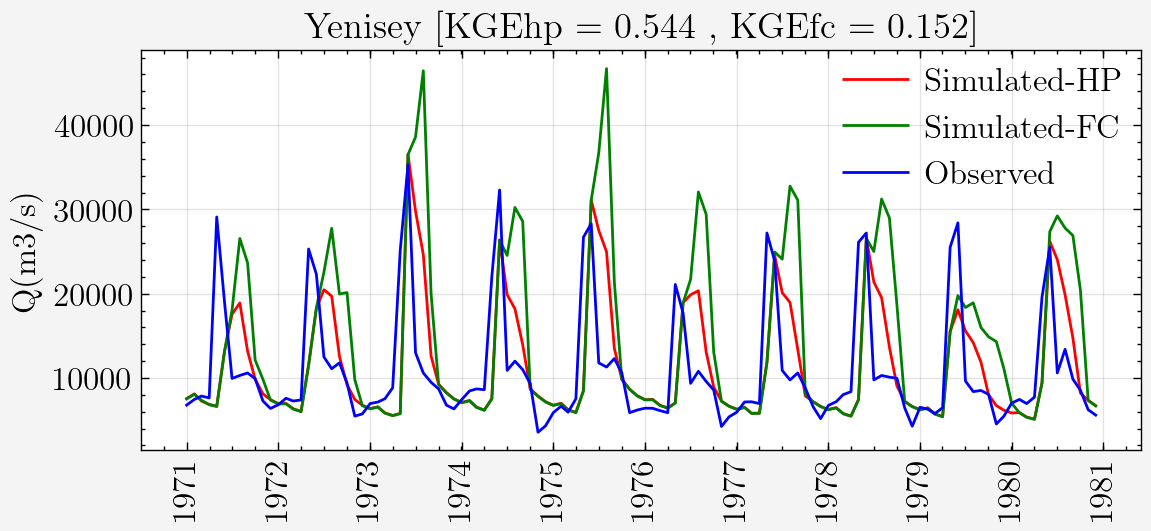

In [6]:
SAVE_KWDS = {"bbox_inches": "tight", "dpi": 450, "facecolor": "w"}

grdc_basin_m3persec  =  pd.read_csv('D:/XanthosDev/example/input/calibration/grdc_95basin_m3persec_1971_1990_monthly.csv')


#basin_4 = basins94[mm]
fig, ax = pplt.subplots(ncols=1, nrows=1,refaspect=1, refheight=2.0, refwidth=5.0, share=0)

basin_slt = [57, 32, 77, 110, 233, 146]
basin_num = 48   
ii = np.where(basins94==basin_num)[0][0]

basin_num = basins94[ii]    
## observed
aa = (grdc_basin_m3persec['basin'] == basin_num)
grdc_m3persec = np.array(grdc_basin_m3persec[aa]['q'])
qobs_calibration= grdc_m3persec[0:120]
qobs_validation = grdc_m3persec[120:240]    
qobs_calibration_ts = timeseries_coverter(qobs_calibration, start_yr=1971, ending_yr=1980)





## simulated v1
file_dir_watch_vald = 'D:\\XanthosDev\\Results-02-27-2022\\Simulated\\SimulatedFinal-v1\\flow\\'
data_basin = np.load(file_dir_watch_vald + 'SimFlow_' + str(basin_num) + '.npy')   
qsim_calibrationv1= data_basin[0:120]
qsim_calibration_tsv1 = timeseries_coverter(qsim_calibrationv1, start_yr=1971, ending_yr=1980)

## simulated v2
file_dir_watch_vald = 'D:\\XanthosDev\\Results-02-27-2022\\Simulated\\SimulatedFinal-v2\\flow\\'
data_basin = np.load(file_dir_watch_vald + 'SimFlow_' + str(basin_num) + '.npy')   
qsim_calibrationv2= data_basin[0:120]
qsim_calibration_tsv2 = timeseries_coverter(qsim_calibrationv2, start_yr=1971, ending_yr=1980)



# KGE
kge_v1 = spotpy.objectivefunctions.kge(qobs_calibration, qsim_calibrationv1) 
kge_v2 = spotpy.objectivefunctions.kge(qobs_calibration, qsim_calibrationv2) 

ax[0].plot(qsim_calibration_tsv1, 'r', label='Simulated-HP')
ax[0].plot(qsim_calibration_tsv2, 'g', label='Simulated-FC')
ax[0].plot(qobs_calibration_ts, 'b', label='Observed')
ax[0].format(ylabel = 'Q(m3/s)', title = basinName_94[ii])
ax[0].format(ylabel = 'Q(m3/s)', title = basinName_94[ii] + ' [KGEhp = '+ str(np.round(kge_v1,3)) + ' , ' + 'KGEfc = '+ str(np.round(kge_v2,3)) +']')
ax[0].legend(ncols=1)